In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import imp
from perceiver_basic import model
from torch.utils.data import DataLoader
from collections.abc import Iterable

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class FMPreprocess(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.shape = (1, 28, 28)
        self.encoding = self._generate_encoding()
        self.encoding = torch.nn.Parameter(self.encoding)
        self.encoding.requires_grad = False

    def _generate_encoding(self):
        dims = len(self.shape)-1 #minus batch dim
        encoding = torch.zeros([*self.shape, dims])
        for i in range(encoding[0].shape[0]):
            for j in range(encoding[0].shape[1]):
                encoding[0,i,j][0] = i * 2.0 / encoding[0].shape[0] - 1.0
                encoding[0,i,j][1] = i * 2.0 / encoding[0].shape[0] - 1.0
        return encoding

    def forward(self, in_val):
        x = in_val.squeeze().clone()
        x = x.unsqueeze(-1)
        if in_val.shape[0] == 1:
            x = x.unsqueeze(0)
        batch_count = in_val.shape[0]
        dims = [-1 for _ in range(len(self.encoding.shape))]
        dims[0] = batch_count
        encoding = self.encoding.expand(*dims)
        x = torch.cat([x, encoding], dim=-1) #concatenating positional encodings
        #x = torch.mul(x, encoding) #scaled positional encooding
        
        #maintain batch and pixel codes, pixels will be in sequential form
        x = torch.flatten(x, start_dim=1, end_dim=-2)

        return x

In [4]:
pre = FMPreprocess()
garbo = torch.randn([5, 28, 28])
pre(garbo).shape

torch.Size([5, 784, 3])

In [19]:
imp.reload(model)
class PerceiverClassify(torch.nn.Module):
    def __init__(self, latent_dim, heads, wide_factor, latent_count, repeat_count=1, p_dropout=0.1):
        super().__init__()
        self.preprocess = FMPreprocess()
        out_dim = (1,32)
        in_channels = len(self.preprocess.shape) #subtract one for batch dim, but add one for the pixel dim
        #in_channels = 1
        self.perceiver = model.PerceiverInternal(in_channels, latent_dim, out_dim, heads, wide_factor, latent_count, repeat_count, p_dropout)
        
        self.lin_out = torch.nn.Linear(32, 10)
        self.softmax = torch.nn.Softmax(-1)

    def forward(self, x):
        #x = x / self.range
        x = self.preprocess(x)

        x = self.perceiver(x)
      
        # x.shape <- (batch_count, 1, 32)
        x = x.squeeze()
        x = self.lin_out(x)
        x = self.softmax(x)

        return x

In [ ]:
class GarbageNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.garbo = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear
        )

In [20]:
per = PerceiverClassify(latent_dim=(32, 32), heads=8, wide_factor=4, latent_count=1)
garbo = torch.randn([3, 28, 28])
per(garbo).shape

torch.Size([3, 10])

In [21]:
mh = torch.nn.MultiheadAttention(32, 8, vdim=7, kdim=7, batch_first=True)
q = torch.randn([3, 2, 32])
kv = torch.randn([3, 6, 7])
mh(q, kv, kv)[0].shape

torch.Size([3, 2, 32])

In [22]:
BATCH_SIZE = 64
EPOCHS = 10

In [23]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST('./fm_set', transform=transforms, download=True)
testset = torchvision.datasets.FashionMNIST('./fm_set', train=False, transform=transforms, download=True)

In [24]:
torch.min(dataset[0][0])

tensor(0.)

In [25]:
dataloader = DataLoader(dataset, num_workers=2, batch_size=BATCH_SIZE)

In [26]:
perceiver = PerceiverClassify(latent_dim=(32, 32), heads=8, wide_factor=4, latent_count=1)
perceiver.to(device)
optimizer = torch.optim.Adam(perceiver.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [27]:
garbo = torch.randn([1, 28, 28])
garbo = garbo.to(device)
perceiver(garbo).shape

torch.Size([10])

In [28]:
def get_grad(x):
    if x.grad != None:
        grad = x.grad.detach().cpu()
        
    return -69

In [29]:
torch.tensor([1]).shape

torch.Size([1])

In [30]:
def ret_grad_list(params):
    if isinstance(params, torch.Tensor) and len(params.shape) == 0:
        return [params.grad]
    garbo = [ret_grad_list(param) for param in params]
    product = []
    for garb in garbo:
        product += garb
    return product

Entering epoch 0
Iteration - 0 - loss 2.2997303009033203
Iteration - 1 - loss 2.3055336475372314
Iteration - 2 - loss 2.31356143951416
Iteration - 3 - loss 2.301845073699951
Iteration - 4 - loss 2.3034780025482178
Iteration - 5 - loss 2.296827554702759
Iteration - 6 - loss 2.3090598583221436
Iteration - 7 - loss 2.3049447536468506
Iteration - 8 - loss 2.303839683532715
Iteration - 9 - loss 2.3010120391845703
Iteration - 10 - loss 2.302304267883301
Iteration - 11 - loss 2.3046321868896484
Iteration - 12 - loss 2.2980263233184814
Iteration - 13 - loss 2.2990262508392334
Iteration - 14 - loss 2.308372735977173
Iteration - 15 - loss 2.2983665466308594
Iteration - 16 - loss 2.3004612922668457
Iteration - 17 - loss 2.3014004230499268
Iteration - 18 - loss 2.2997806072235107
Iteration - 19 - loss 2.307196617126465
Iteration - 20 - loss 2.305107593536377
Iteration - 21 - loss 2.3082401752471924
Iteration - 22 - loss 2.296569585800171
Iteration - 23 - loss 2.2929959297180176
Iteration - 24 - lo

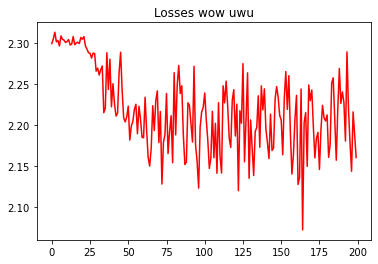

Iteration - 200 - loss 2.2071008682250977
Iteration - 201 - loss 2.2194888591766357
Iteration - 202 - loss 2.2381317615509033
Iteration - 203 - loss 2.1954197883605957
Iteration - 204 - loss 2.12658953666687
Iteration - 205 - loss 2.2077548503875732
Iteration - 206 - loss 2.2069554328918457
Iteration - 207 - loss 2.1307740211486816
Iteration - 208 - loss 2.204704523086548
Iteration - 209 - loss 2.187204122543335
Iteration - 210 - loss 2.235460042953491
Iteration - 211 - loss 2.176755666732788
Iteration - 212 - loss 2.2451319694519043
Iteration - 213 - loss 2.1447858810424805
Iteration - 214 - loss 2.1807031631469727
Iteration - 215 - loss 2.1816248893737793
Iteration - 216 - loss 2.250288486480713
Iteration - 217 - loss 2.137042284011841
Iteration - 218 - loss 2.220478057861328
Iteration - 219 - loss 2.195880174636841
Iteration - 220 - loss 2.2073512077331543
Iteration - 221 - loss 2.260986089706421
Iteration - 222 - loss 2.2362608909606934
Iteration - 223 - loss 2.216566324234009
Iter

Iteration - 398 - loss 2.1833112239837646
Iteration - 399 - loss 2.2460854053497314


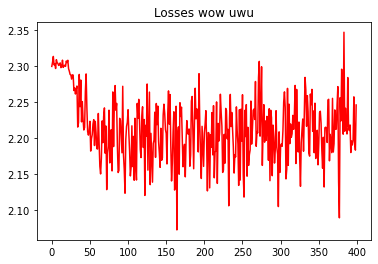

Iteration - 400 - loss 2.1870672702789307
Iteration - 401 - loss 2.1974029541015625
Iteration - 402 - loss 2.2510361671447754
Iteration - 403 - loss 2.234879732131958
Iteration - 404 - loss 2.1820409297943115
Iteration - 405 - loss 2.230253219604492
Iteration - 406 - loss 2.234938383102417
Iteration - 407 - loss 2.2412211894989014
Iteration - 408 - loss 2.2442328929901123
Iteration - 409 - loss 2.239227533340454
Iteration - 410 - loss 2.2094287872314453
Iteration - 411 - loss 2.1919286251068115
Iteration - 412 - loss 2.1654574871063232
Iteration - 413 - loss 2.1902694702148438
Iteration - 414 - loss 2.1740124225616455
Iteration - 415 - loss 2.2322440147399902
Iteration - 416 - loss 2.1582391262054443
Iteration - 417 - loss 2.1673505306243896
Iteration - 418 - loss 2.201105833053589
Iteration - 419 - loss 2.107959508895874
Iteration - 420 - loss 2.161435127258301
Iteration - 421 - loss 2.226386308670044
Iteration - 422 - loss 2.1812167167663574
Iteration - 423 - loss 2.1844751834869385


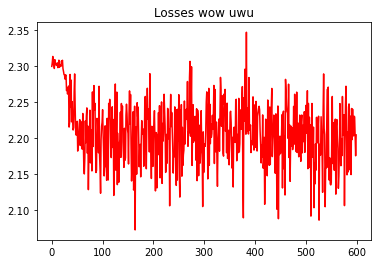

Iteration - 600 - loss 2.2375667095184326
Iteration - 601 - loss 2.1699178218841553
Iteration - 602 - loss 2.2165896892547607
Iteration - 603 - loss 2.1879584789276123
Iteration - 604 - loss 2.1377205848693848
Iteration - 605 - loss 2.1581969261169434
Iteration - 606 - loss 2.2041947841644287
Iteration - 607 - loss 2.19810152053833
Iteration - 608 - loss 2.119781732559204
Iteration - 609 - loss 2.1987643241882324
Iteration - 610 - loss 2.173919916152954
Iteration - 611 - loss 2.1542818546295166
Iteration - 612 - loss 2.1954047679901123
Iteration - 613 - loss 2.1589579582214355
Iteration - 614 - loss 2.1774561405181885
Iteration - 615 - loss 2.16064190864563
Iteration - 616 - loss 2.2493577003479004
Iteration - 617 - loss 2.2293195724487305
Iteration - 618 - loss 2.2018187046051025
Iteration - 619 - loss 2.261897563934326
Iteration - 620 - loss 2.259026050567627
Iteration - 621 - loss 2.232428789138794
Iteration - 622 - loss 2.2751388549804688
Iteration - 623 - loss 2.238945960998535
It

Iteration - 798 - loss 2.1255362033843994
Iteration - 799 - loss 2.2341084480285645


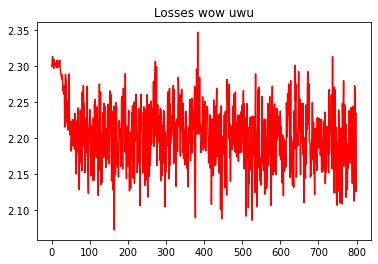

Iteration - 800 - loss 2.277367115020752
Iteration - 801 - loss 2.2130320072174072
Iteration - 802 - loss 2.202399730682373
Iteration - 803 - loss 2.1811845302581787
Iteration - 804 - loss 2.1867992877960205
Iteration - 805 - loss 2.1981711387634277
Iteration - 806 - loss 2.285172462463379
Iteration - 807 - loss 2.1665666103363037
Iteration - 808 - loss 2.1149749755859375
Iteration - 809 - loss 2.1529953479766846
Iteration - 810 - loss 2.1476502418518066
Iteration - 811 - loss 2.164076328277588
Iteration - 812 - loss 2.1754446029663086
Iteration - 813 - loss 2.140397310256958
Iteration - 814 - loss 2.2001473903656006
Iteration - 815 - loss 2.120396137237549
Iteration - 816 - loss 2.2060160636901855
Iteration - 817 - loss 2.226855754852295
Iteration - 818 - loss 2.140185832977295
Iteration - 819 - loss 2.217181921005249
Iteration - 820 - loss 2.22353458404541
Iteration - 821 - loss 2.2260422706604004
Iteration - 822 - loss 2.167520523071289
Iteration - 823 - loss 2.2274022102355957
Iter

Iteration - 61 - loss 2.248828887939453
Iteration - 62 - loss 2.161339044570923
Iteration - 63 - loss 2.1455485820770264
Iteration - 64 - loss 2.12382435798645
Iteration - 65 - loss 2.1479856967926025
Iteration - 66 - loss 2.1879281997680664
Iteration - 67 - loss 2.192657947540283
Iteration - 68 - loss 2.2262027263641357
Iteration - 69 - loss 2.2074501514434814
Iteration - 70 - loss 2.1631131172180176
Iteration - 71 - loss 2.123453140258789
Iteration - 72 - loss 2.143247365951538
Iteration - 73 - loss 2.1706326007843018
Iteration - 74 - loss 2.208801746368408
Iteration - 75 - loss 2.2327158451080322
Iteration - 76 - loss 2.1239821910858154
Iteration - 77 - loss 2.194610357284546
Iteration - 78 - loss 2.1985044479370117
Iteration - 79 - loss 2.1319844722747803
Iteration - 80 - loss 2.318938970565796
Iteration - 81 - loss 2.191648244857788
Iteration - 82 - loss 2.2232565879821777
Iteration - 83 - loss 2.252366304397583
Iteration - 84 - loss 2.209545135498047
Iteration - 85 - loss 2.22811

KeyboardInterrupt: 

In [31]:
losses = []
for epoch in range(EPOCHS):
    print(f"Entering epoch {epoch}")
    perceiver.train()
    for batch_no, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        predictions = perceiver(features)
        
        loss = criterion(predictions, labels)
        optimizer.zero_grad()        
        loss.backward()
        
        optimizer.step()

        print(f'Iteration - {batch_no} - loss {loss.item()}')
        losses.append(loss.item())
        if batch_no % 200 == 199:
            plt.plot(losses, 'r-')
            plt.title('Losses wow uwu')
            plt.show()

In [ ]:
perceiver(dataset[0][0].to(device))

In [32]:
testloader = DataLoader(testset, batch_size=1)
acc_count = 0
count = 0
perceiver.eval()
for i, (feature, label) in enumerate(testloader):
    feature = feature.to(device)
    label = label.to(device)
    prediction = perceiver(feature)
    prediction = torch.argmax(prediction)
    
    if prediction == label:
        acc_count += 1
        
    count += 1
    
    if i == 500:
        break
        
print(acc_count / count)

0.20958083832335328
